In [1]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import cmocean.cm as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dask.distributed import Client
client = Client()

/home/dylan/.local/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33393 instead
  http_address["port"], self.http_server.port


In [2]:
ds = xroms.xroms.open_netcdf('/d1/shared/shelf_ho_0_dh_0_vwind_0_his.nc', 
                             chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, Vtransform = None)

#Select a small box for quick testing
xislice=slice(10,20)
etaslice=slice(10,20)
tslice = slice(50,481)

/home/dylan/.local/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/dylan/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


#### Select salt

In [3]:
su = grid.interp(ds.salt, 'X')
sv = grid.interp(ds.salt, 'Y')

su = su.sel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop)) #need to take -1 bc it's at u points
sv = sv.sel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

sW = su.isel(xi_u = 0) 
sE = su.isel(xi_u = -1) 
sN = sv.isel(eta_v = -1) 
sS = sv.isel(eta_v = 0) 

sW.name = 'salt'
sE.name = 'salt'
sN.name = 'salt'
sS.name = 'salt'

#### Select Volume Flux

In [4]:
Qu = ds.dz_u*ds.dy_u*ds.u
Qv = ds.dz_v*ds.dx_v*ds.v

Qu = Qu.sel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
Qv = Qv.sel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

QW = Qu.isel(xi_u = 0) #west
QE = Qu.isel(xi_u = -1) #east
QN = Qv.isel(eta_v = -1) #top
QS = Qv.isel(eta_v = 0) #bottom

QW.name = 'Q'
QE.name = 'Q'
QN.name = 'Q'
QS.name = 'Q'

#### Calculate Salt Flux

In [7]:
QsW = QW*sW #west
QsE = QE*sE #east
QsN = QN*sN #top
QsS = QS*sS #bottom

QsW.name = 'Qs'
QsE.name = 'Qs'
QsN.name = 'Qs'
QsS.name = 'Qs'

In [8]:
saltbins = np.linspace(0,40,101)

#### Bin Data in salinity coordinates

In [9]:
qsWh = histogram(sW.isel(ocean_time = tslice), bins = [saltbins], weights = QsW.isel(ocean_time = tslice),
                 dim = ['s_rho', 'eta_rho'])
qsEh = histogram(sE.isel(ocean_time = tslice), bins = [saltbins], weights = QsE.isel(ocean_time = tslice),
                  dim = ['s_rho', 'eta_rho'])
qsNh = histogram(sN.isel(ocean_time = tslice), bins = [saltbins], weights = QsN.isel(ocean_time = tslice),
                  dim = ['s_rho', 'xi_rho'])
qsSh = histogram(sS.isel(ocean_time = tslice), bins = [saltbins], weights = QsS.isel(ocean_time = tslice),
                  dim = ['s_rho', 'xi_rho'])


qWh = histogram(sW.isel(ocean_time = tslice), bins = [saltbins], weights = QW.isel(ocean_time = tslice),
                 dim = ['s_rho', 'eta_rho'])
qEh = histogram(sE.isel(ocean_time = tslice), bins = [saltbins], weights = QE.isel(ocean_time = tslice),
                  dim = ['s_rho', 'eta_rho'])
qNh = histogram(sN.isel(ocean_time = tslice), bins = [saltbins], weights = QN.isel(ocean_time = tslice),
                  dim = ['s_rho', 'xi_rho'])
qSh = histogram(sS.isel(ocean_time = tslice), bins = [saltbins], weights = QS.isel(ocean_time = tslice),
                  dim = ['s_rho', 'xi_rho'])

#### Compute TEF

In [ ]:
# qn = ((qWh+qSh)).where((qWh+qSh)<0).sum('salt_bin')
# qp = ((qEh+qNh)).where((qEh+qNh)>0).sum('salt_bin')

# Qnetout = qn-qp

# qn1 = ((qWh+qSh)).where((qWh+qSh)>0).sum('salt_bin')
# qp1 = ((qEh+qNh)).where((qEh+qNh)<0).sum('salt_bin')

# Qnetin = qn1-qp1

# qsn = ((qsWh+qsSh)).where((qWh+qSh)<0).sum('salt_bin')
# qsp = ((qsEh+qsNh)).where((qEh+qNh)>0).sum('salt_bin')

# Qsnetout = qsn-qsp

# qsn1 = ((qsWh+qsSh)).where((qWh+qSh)>0).sum('salt_bin')
# qsp1 = ((qsEh+qsNh)).where((qEh+qNh)<0).sum('salt_bin')

# Qsnetin = qsn1-qsp1

In [15]:
#Volume Flux
qnet = (qWh-qEh+qSh-qNh)

#Salinity Flux
qsnet = (qsWh-qsEh+qsSh-qsNh)

Qnetout2 = (qnet.where(qsnet<0).sum('salt_bin'))
Qnetin2 = (qnet.where(qsnet>0).sum('salt_bin'))

Qsnetout2 = (qsnet.where(qsnet<0).sum('salt_bin'))
Qsnetin2 = (qsnet.where(qsnet>0).sum('salt_bin'))

In [ ]:
# (Qsnetout2+Qsnetin2)[:50].plot()
# (Qsnetout+Qsnetin)[:50].plot()

Don't fill salt NaNs with zero because that physically doesn't make since. Apply it to the net advection instead.

In [17]:
sin = (Qsnetin/Qnetin)
sout = (Qsnetout/Qnetout)

In [18]:
voladv = (Qnetin+Qnetout)
saltadv = (Qnetin*sin).fillna(0)+(Qnetout*sout).fillna(0)

In [19]:
V = ((ds.dx*ds.dy*ds.dz)).isel(ocean_time = tslice,
                             eta_rho = etaslice, 
                             xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
V = V.chunk(3)
dVdt = V.differentiate('ocean_time', datetime_unit = 's')

dsV = ((ds.dx*ds.dy*ds.dz*ds.salt)).isel(ocean_time = tslice,
                                         eta_rho = etaslice, 
                                         xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
dsV = dsV.chunk(3)
dsVdt = dsV.differentiate('ocean_time', datetime_unit = 's')

In [20]:
v1 = voladv.values
v2 = dVdt.values

In [21]:
print(v1.sum())
print(v2.sum())

-698.3339712043498
-697.3577832320443


$\frac{dV}{dt} = Q_{in}+Q_{out}$

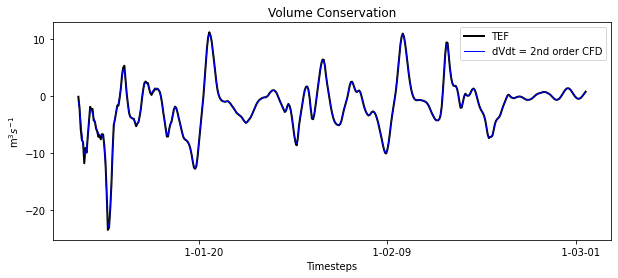

In [22]:
fig = plt.subplots(1, figsize = (10,4))

plt.plot(ds.ocean_time[50:481], voladv, lw = 2, color = 'k', label = 'TEF')
plt.plot(ds.ocean_time[50:481], dVdt, lw = 1, color = 'b', label = 'dVdt = 2nd order CFD')
plt.title('Volume Conservation')
plt.xlabel('Timesteps')
plt.ylabel('m$^3 s^{-1}$')
plt.legend()
plt.rcParams.update({'font.size': 16})

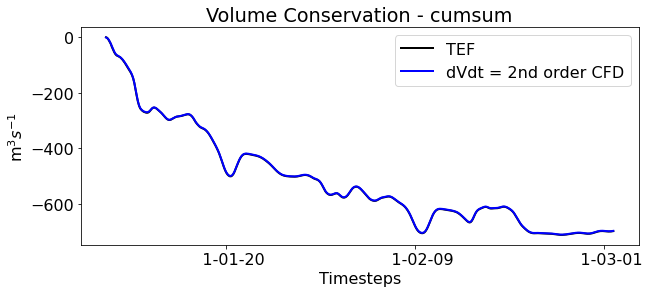

In [24]:
fig = plt.subplots(1, figsize = (10,4))

plt.plot(ds.ocean_time[50:481],voladv.cumsum(), lw = 2, color = 'k', label = 'TEF')
plt.plot(ds.ocean_time[50:481],dVdt.cumsum(), lw = 2, color = 'b', label = 'dVdt = 2nd order CFD')
# plt.plot(ds.ocean_time[50:480],dvdtdiff, lw = 2, color = 'r', label = 'dVdt = diff')
plt.title('Volume Conservation - cumsum')
plt.xlabel('Timesteps')
plt.ylabel('m$^3 s^{-1}$')
plt.legend()
plt.rcParams.update({'font.size': 16})
# plt.plot(dvdtdiff, color = 'r', label = 'diff')

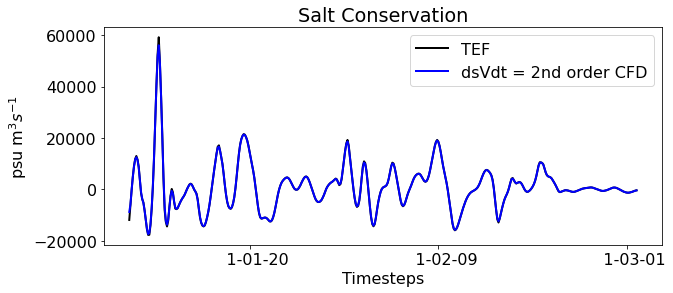

In [25]:
fig = plt.subplots(1, figsize = (10,4))

plt.plot(ds.ocean_time[50:481], saltadv, lw = 2, color = 'k', label = 'TEF')
plt.plot(ds.ocean_time[50:481], dsVdt, lw = 2, color = 'b', label = 'dsVdt = 2nd order CFD')
# plt.plot(V.diff(dim = 'ocean_time')/(3600*3), lw = 2, color = 'r', label = 'dVdt = diff')
plt.title('Salt Conservation')
plt.xlabel('Timesteps')
plt.ylabel('psu m$^3 s^{-1}$')
plt.legend()
plt.rcParams.update({'font.size': 16})
# plt.plot(dvdtdiff, color = 'r', label = 'diff')

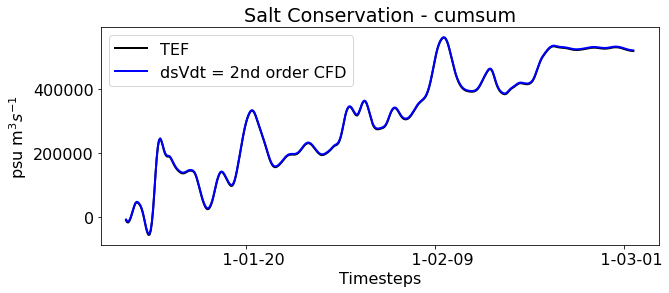

In [26]:
fig = plt.subplots(1, figsize = (10,4))

plt.plot(ds.ocean_time[50:481],saltadv.cumsum(), lw = 2, color = 'k', label = 'TEF')
plt.plot(ds.ocean_time[50:481],dsVdt.cumsum(), lw = 2, color = 'b', label = 'dsVdt = 2nd order CFD')
plt.title('Salt Conservation - cumsum')
plt.xlabel('Timesteps')
plt.ylabel('psu m$^3 s^{-1}$')
plt.legend()
plt.rcParams.update({'font.size': 16})
# plt.plot(dvdtdiff, color = 'r', label = 'diff')

#### Let's test out salt squared and salt variance

In [28]:
QssW = QW*(sW**2) #west
QssE = QE*(sE**2) #east
QssN = QN*(sN**2) #top
QssS = QS*(sS**2) #bottom

QssW.name = 'Qss'
QssE.name = 'Qss'
QssN.name = 'Qss'
QssS.name = 'Qss'

In [29]:
qssWh = histogram(sW.isel(ocean_time = tslice), bins = [saltbins], weights = (QssW).isel(ocean_time = tslice),
                 dim = ['s_rho', 'eta_rho'])
qssEh = histogram(sE.isel(ocean_time = tslice), bins = [saltbins], weights = (QssE).isel(ocean_time = tslice),
                  dim = ['s_rho', 'eta_rho'])
qssNh = histogram(sN.isel(ocean_time = tslice), bins = [saltbins], weights = (QssN).isel(ocean_time = tslice),
                  dim = ['s_rho', 'xi_rho'])
qssSh = histogram(sS.isel(ocean_time = tslice), bins = [saltbins], weights = (QssS).isel(ocean_time = tslice),
                  dim = ['s_rho', 'xi_rho'])

In [30]:
#Salt square
qssnet = (qssWh-qssEh+qssSh-qssNh)

Qssnetout = (qssnet.where(qssnet<0).sum('salt_bin'))
Qssnetin = (qssnet.where(qssnet>0).sum('salt_bin'))

In [18]:
# qssn = ((qssWh+qssSh)).where((qWh+qSh)<0).sum('salt_bin')
# qssp = ((qssEh+qssNh)).where((qEh+qNh)>0).sum('salt_bin')

# Qssnetout = qssn-qssp

# qssn1 = ((qssWh+qssSh)).where((qWh+qSh)>0).sum('salt_bin')
# qssp1 = ((qssEh+qssNh)).where((qEh+qNh)<0).sum('salt_bin')

# Qssnetin = qssn1-qssp1

In [31]:
ssin = (Qssnetin/Qnetin)
ssout = (Qssnetout/Qnetout)

In [32]:
ssaltadv = (Qnetin*ssin).fillna(0)+(Qnetout*ssout).fillna(0)

In [33]:
dssV = ((ds.dx*ds.dy*ds.dz*ds.salt**2)).isel(ocean_time = tslice,
                                         eta_rho = etaslice, 
                                         xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
dssV = dssV.chunk(3)
dssVdt = dssV.differentiate('ocean_time', datetime_unit = 's')

Calculate $\chi$

In [38]:
dsdz = grid.derivative(ds.salt, 'Z', boundary = 'extend')

chi = 2*(ds.AKs*(dsdz**2)).isel(ocean_time = tslice, eta_rho = etaslice, xi_rho = xislice) #salinity variance dissipation

dV = (ds.dx*ds.dy*ds.dz).isel(ocean_time = tslice, eta_rho = etaslice, xi_rho = xislice)
V = dV.sum(dim = ['s_rho', 'eta_rho', 'xi_rho'])

#Interpolate to get chi on the rho points 
chi = grid.interp(chi, 'Z')

chi = (chi*dV).sum(dim = ['s_rho', 'eta_rho', 'xi_rho'])
chitest = chi.rename('xi').values

In [35]:
ssadv = ssaltadv.values
ssdt = dssVdt.values

In [39]:
(ssadv-chitest).sum()/(ssdt.sum())

0.9963173781759249

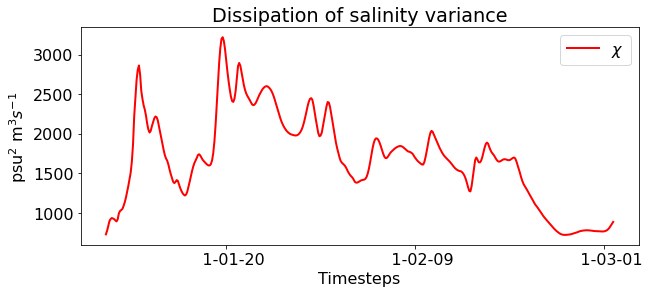

In [40]:
fig = plt.subplots(1, figsize = (10,4))

# plt.plot(ds.ocean_time[50:481], ssadv-chitest, lw = 2, color = 'k', label = '$F^{s^2}_{in}+F^{s^2}_{out}-\chi$')
# plt.plot(ds.ocean_time[50:481], ssdt, lw = 1, color = 'b', label = r'$ \frac{d}{dt} \iiint s^2 dV$')
plt.plot(ds.ocean_time[50:481], chitest, lw = 2, color = 'r', label = '$\chi$')
plt.title('Dissipation of salinity variance')
plt.xlabel('Timesteps')
plt.ylabel('psu$^2$ m$^3 s^{-1}$')
plt.legend()
plt.rcParams.update({'font.size': 16})

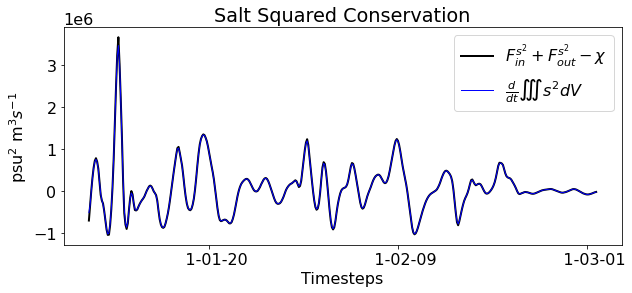

In [41]:
fig = plt.subplots(1, figsize = (10,4))

plt.plot(ds.ocean_time[50:481], ssadv-chitest, lw = 2, color = 'k', label = '$F^{s^2}_{in}+F^{s^2}_{out}-\chi$')
plt.plot(ds.ocean_time[50:481], ssdt, lw = 1, color = 'b', label = r'$ \frac{d}{dt} \iiint s^2 dV$')
# plt.plot(ds.ocean_time[50:481], chitest, lw = 2, color = 'r', label = '$\chi$')
plt.title('Salt Squared Conservation')
plt.xlabel('Timesteps')
plt.ylabel('psu$^2$ m$^3 s^{-1}$')
plt.legend()
plt.rcParams.update({'font.size': 16})

#### Salt Variance

In [42]:
dV = (ds.dx*ds.dy*ds.dz).isel(ocean_time = tslice,
                              eta_rho = etaslice, 
                              xi_rho = xislice)
V = dV.sum(dim = ['eta_rho', 's_rho', 'xi_rho'])
salt = ds.salt.isel(ocean_time = tslice,
                    eta_rho = etaslice, 
                    xi_rho = xislice)

sbar = (1/V)*(salt*dV).sum(dim = ['eta_rho', 'xi_rho','s_rho'])

sbar = sbar.chunk({'ocean_time':500})
salt = salt.chunk({'ocean_time':500})
dV = dV.chunk({'ocean_time':500})

svar = (((salt-sbar)**2)*(dV)).sum(dim = ['eta_rho', 'xi_rho','s_rho'])
dsvardt = svar.differentiate('ocean_time', datetime_unit = 's').values

In [43]:
svarW = ((sW.isel(ocean_time=tslice)-sbar)**2)
svarE = ((sE.isel(ocean_time=tslice)-sbar)**2)
svarN = ((sN.isel(ocean_time=tslice)-sbar)**2)
svarS = ((sS.isel(ocean_time=tslice)-sbar)**2)

QsvarW = QW.isel(ocean_time=tslice)*svarW
QsvarE = QE.isel(ocean_time=tslice)*svarE
QsvarN = QN.isel(ocean_time=tslice)*svarN
QsvarS = QS.isel(ocean_time=tslice)*svarS

In [44]:
qsvarWh = histogram(sW.isel(ocean_time = tslice), bins = [saltbins], weights = (QsvarW),
                 dim = ['s_rho', 'eta_rho'])
qsvarEh = histogram(sE.isel(ocean_time = tslice), bins = [saltbins], weights = (QsvarE),
                  dim = ['s_rho', 'eta_rho'])
qsvarNh = histogram(sN.isel(ocean_time = tslice), bins = [saltbins], weights = (QsvarN),
                  dim = ['s_rho', 'xi_rho'])
qsvarSh = histogram(sS.isel(ocean_time = tslice), bins = [saltbins], weights = (QsvarS),
                  dim = ['s_rho', 'xi_rho'])

In [48]:
#Volume Flux
qsvarnet = (qsvarWh-qsvarEh+qsvarSh-qsvarNh)

Qsvarnetout = (qsvarnet.where(qsvarnet<0).sum('salt_bin'))
Qsvarnetin = (qsvarnet.where(qsvarnet>0).sum('salt_bin'))

In [49]:
# qsvarn = ((qsvarWh+qsvarSh)).where((qsvarWh+qsvarSh)<0).sum('salt_bin')
# qsvarp = ((qsvarEh+qsvarNh)).where((qsvarEh+qsvarNh)>0).sum('salt_bin')

# Qsvarnetout = qsvarn-qsvarp

# qsvarn1 = ((qsvarWh+qsvarSh)).where((qsvarWh+qsvarSh)>0).sum('salt_bin')
# qsvarp1 = ((qsvarEh+qsvarNh)).where((qsvarEh+qsvarNh)<0).sum('salt_bin')

# Qsvarnetin = qsvarn1-qsvarp1

In [50]:
svarin = (Qsvarnetin/Qnetin)
svarout = (Qsvarnetout/Qnetout)

svaradv = ((Qnetin*svarin).fillna(0)+(Qnetout*svarout).fillna(0)).values

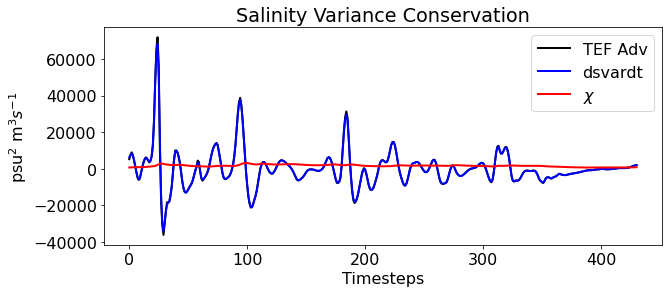

In [51]:
fig = plt.subplots(1, figsize = (10,4))

plt.plot(svaradv-chitest, lw = 2, color = 'k', label = 'TEF Adv')
plt.plot(dsvardt, lw = 2, color = 'b', label = 'dsvardt')
# plt.plot(chitest)
# plt.plot(chitest)
plt.plot(chitest, lw = 2, color = 'r', label = '$\chi$')
# plt.plot(ds.ocean_time[50:480], V.diff(dim = 'ocean_time')/(3600*3), lw = 2, color = 'r', label = 'dVdt = diff')
plt.title('Salinity Variance Conservation')
plt.xlabel('Timesteps')
plt.ylabel('psu$^2$ m$^3 s^{-1}$')
plt.legend()
plt.rcParams.update({'font.size': 16})

In [55]:
(svaradv-chitest).sum()/dsvardt.sum()

0.9505968062493445

#### Conclusion - all budgets are closed in the idealized base case. The largest error is in the salinity variance budget, which occurs during the spin up time at one disctinct peak and trough. To do - turn this into function to develop TEF into a package

#### Make plot of base case location. Also experiment with the indexing to make the code more efficient

In [488]:
su = grid.interp(ds.salt, 'X')
sv = grid.interp(ds.salt, 'Y')

sEW = su.isel(eta_rho= etaslice, xi_u = [xislice.start-1, xislice.stop])
sNS = sv.isel(eta_v = [etaslice.start-1, etaslice.stop], xi_rho = xislice)

#Need to scale grid indices up to slices
sEW['xi_u'] = sEW.xi_u+[xislice.start-1, xislice.stop-1]
sEW['eta_rho'] = sEW.eta_rho+etaslice.start

sNS['xi_rho'] = sNS.xi_rho+xislice.start
sNS['eta_v'] = sNS.eta_v+[etaslice.start-1, etaslice.stop-1]

sEW.name = 'salt'
sNS.name = 'salt'

In [489]:
print(sNS.xi_rho.values)
print(sEW.xi_u.values)
print(sNS.eta_v.values)
print(sEW.eta_rho.values)

[10 11 12 13 14 15 16 17 18 19]
[ 9 20]
[ 9 20]
[10 11 12 13 14 15 16 17 18 19]


(8.0, 21.0)

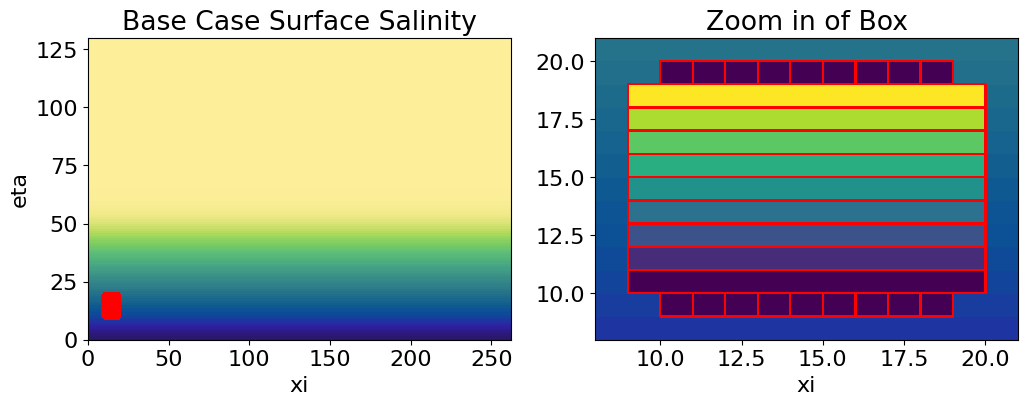

In [493]:
fig, ax = plt.subplots(1,2, figsize = (12,4), dpi = 100)

ax[0].pcolormesh(ds.salt[0,-1], cmap = cmo.haline)
ax[0].pcolormesh(sNS.xi_rho,sNS.eta_v, sNS[0,-1], color = 'r')
ax[0].pcolormesh(sEW.xi_u,sEW.eta_rho, sEW[0,-1], color = 'r')
ax[0].set_xlabel('xi')
ax[1].set_xlabel('xi')
ax[0].set_ylabel('eta')
ax[0].set_title('Base Case Surface Salinity')
ax[1].set_title('Zoom in of Box')

ax[1].pcolormesh(ds.salt[0,-1], cmap = cmo.haline)
# ax.plot(sEW.xi_u,sEW.eta_rho, color = 'r')
ax[1].pcolormesh(sNS.xi_rho,sNS.eta_v, sNS[0,-1], color = 'r')
ax[1].pcolormesh(sEW.xi_u,sEW.eta_rho, sEW[0,-1], color = 'r')

ax[1].set_xlim(8,21)
ax[1].set_ylim(8,21)


In [ ]:
Qu = ds.dz_u*ds.dy_u*ds.u
Qv = ds.dz_v*ds.dx_v*ds.v

QEW = Qu.isel(eta_rho= etaslice, xi_u = [xislice.start-1, xislice.stop])
QNS = Qv.isel(eta_v = [etaslice.start-1, etaslice.stop], xi_rho = xislice)

#Need to scale grid indices up to slices
# QEW['xi_u'] = QEW.xi_u+[xislice.start-1, xislice.stop-1]
# QEW['eta_rho'] = QEW.eta_rho+etaslice.start

# QNS['xi_rho'] = QNS.xi_rho+xislice.start
# QNS['eta_v'] = QNS.eta_v+[etaslice.start-1, etaslice.stop-1]

QEW.name = 'Q'
QNS.name = 'Q'

In [ ]:
QsEW = QEW*sEW
QsNS = QNS*sNS

QsEW.name = 'Qs'
QsNS.name = 'Qs'
# QsN.name = 'QsN'
# QsS.name = 'QsS'

In [ ]:
saltbins = np.linspace(20,40,501)

In [ ]:
qWh = histogram(sEW.isel(ocean_time=tslice, xi_u=0), bins = [saltbins], 
                weights = QEW.isel(ocean_time=tslice, xi_u=0),
                dim = ['s_rho', 'eta_rho'])
qEh = histogram(sEW.isel(ocean_time=tslice, xi_u=-1), bins = [saltbins], 
                weights = QEW.isel(ocean_time=tslice, xi_u=-1),
                dim = ['s_rho', 'eta_rho'])
qNh = histogram(sNS.isel(ocean_time=tslice, eta_v = -1), bins = [saltbins],
                weights = QNS.isel(ocean_time=tslice, eta_v = -1),
                dim = ['s_rho', 'xi_rho'])
qSh = histogram(sNS.isel(ocean_time=tslice, eta_v = 0), bins = [saltbins], 
                weights = QNS.isel(ocean_time=tslice, eta_v = 0),
                dim = ['s_rho', 'xi_rho'])

qsWh = histogram(sEW.isel(ocean_time=tslice, xi_u = 0), bins = [saltbins], 
                 weights = QsEW.isel(ocean_time=tslice, xi_u=0),
                 dim = ['s_rho', 'eta_rho'])
qsEh = histogram(sEW.isel(ocean_time=tslice, xi_u = -1), bins = [saltbins], 
                 weights = QsEW.isel(ocean_time=tslice, xi_u=-1),
                 dim = ['s_rho', 'eta_rho'])
qsNh = histogram(sNS.isel(ocean_time=tslice, eta_v = -1), bins = [saltbins], 
                 weights = QsNS.isel(ocean_time=tslice, eta_v = -1),
                 dim = ['s_rho', 'xi_rho'])
qsSh = histogram(sNS.isel(ocean_time=tslice, eta_v = 0), bins = [saltbins], 
                 weights = QsNS.isel(ocean_time=tslice, eta_v = 0),
                 dim = ['s_rho', 'xi_rho'])

In [ ]:
(qsWh-qsEh).sum(axis=1).plot()
(qsSh-qsNh).sum(axis=1).plot()
# qsEh.sum(axis=1).plot()

In [ ]:
#Volume Flux
qnet = (qWh-qEh+qSh-qNh)

#Salinity Flux
qsnet = (qsWh-qsEh+qsSh-qsNh)

In [ ]:
(qsnet/qnet).sum(axis=1).plot()